# Define EBUS Coastal Distance

** NOTE ** : This method is dead to me. It really isn't a great solution and is too much of a time sink.

It came to my attention that my method for creating the EBUS "regions" was not so robust. Also, I found that I was totally in the wrong spot for the Canary Current.

As a result, I will try a new method of defining these regions. I'm thinking of defining a latitude band of coastline (e.g. 10 degrees of latitude) and then converting the lat/lon of those coastal cells to a list of tuples. Then, I will compute a distance to coastline function with reference to every cell for the global grid, and then filter by being within some range.

In [117]:
import numpy as np
import pandas as pd
import xarray as xr

import esmtools as et

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

import geopy.distance

In [130]:
fileDir = '/glade/u/home/rbrady/scratch/EBUS_BGC_Variability/FG_CO2_monthly/'
fileName = 'FG_CO2.001.192001-210012.nc'
ds = xr.open_dataset(fileDir + fileName, decode_times=False)

In [131]:
# Strip down the example file to the lat/long coordinates we need.
ds2 = ds['FG_CO2'][0]
ds2['REGION_MASK'] = ds['REGION_MASK']
del ds2['ULAT']
del ds2['ULONG']
del ds2['time']

# California Current

From Chavez et al. 2009:

LAT : 34N - 44N

LON : 130W - 115W

In [32]:
# Pull out a small box around the CalCS to find the coastline.
a, c = et.filtering.find_indices(ds2.TLONG, ds2.TLAT,
                                 230, 34)
b, d = et.filtering.find_indices(ds2.TLONG, ds2.TLAT,
                                 245, 44)

# Slice out this region
ds2 = ds2.sel(nlat=slice(a,b), nlon=slice(c,d))

In [33]:
# Slim it down to right up to the coastline. Everything is now NaN'ed out
# because any Pacific cells turned to NaN for not being coastline.
# Reference the region_mask portion now
coastal_region = ds2.where(ds2['REGION_MASK'] == 0, drop=True).REGION_MASK

# Find where the first instance of the coastline is.
lon_coastal_index = np.argmax(coastal_region==0, axis=1).values
lat_coastal_index = np.arange(0, coastal_region.shape[0], 1)

# Pointwise indexing to grab those cells
coastline = coastal_region.isel_points(nlat=lat_coastal_index,
                                       nlon=lon_coastal_index)

# Pull out a list for lon and lat
lon_coords = np.asarray(coastline.TLONG) - 360
lat_coords = np.asarray(coastline.TLAT)

# Combine into one 20x2 array with these coordinates.
coastal_coordinates = np.array([lon_coords, lat_coords]).transpose()

In [47]:
global_grid = ds['FG_CO2'][0]

In [48]:
test = global_grid.where((global_grid.TLAT > 0) & (global_grid.TLAT < 60), drop=True)
test = test.where((test.TLONG > 180) & (test.TLONG <300), drop=True)

In [49]:
%%time
dims = test.shape
dist_grid = np.zeros((dims[0], dims[1]))
for i in np.arange(0, dims[0], 1):
    for j in np.arange(0, dims[1], 1):
        if np.isnan(test[i,j]):
            dist_grid[i,j] = np.nan
        else:
            # Coordinates of point on grid.
            if test[i,j].TLONG > 180:
                xpoint = test[i,j].TLONG.values - 360
            else:
                xpoint = test[i,j].TLONG.values
            ypoint = test[i,j].TLAT.values
            grid_coords = (xpoint, ypoint)
            
            # Check distances to every coastal point.
            temp_distance = np.zeros((coastal_coordinates.shape[0]))
            for idx, coords in enumerate(coastal_coordinates):
                temp_distance[idx] = geopy.distance.vincenty(grid_coords, (coords[0], coords[1])).km                
            dist_grid[i,j] = np.nanmin(temp_distance)

CPU times: user 37.1 s, sys: 4 ms, total: 37.1 s
Wall time: 37.1 s


In [76]:
dist2cal = xr.DataArray(dist_grid, dims=['nlat','nlon'])
dist2cal['TLAT'] = test['TLAT']
dist2cal['TLONG'] = test['TLONG']

In [77]:
dist2cal.name = 'dist2cal'

In [113]:
CalCS = dist2cal.where((dist2cal <= 800) & (dist2cal.TLAT > 34) & (dist2cal.TLAT < 44))

/glade/u/home/rbrady/.local/lib/python3.6/site-packages/xarray/core/variable.py:1193: RuntimeWarning: invalid value encountered in less_equal
  if not reflexive


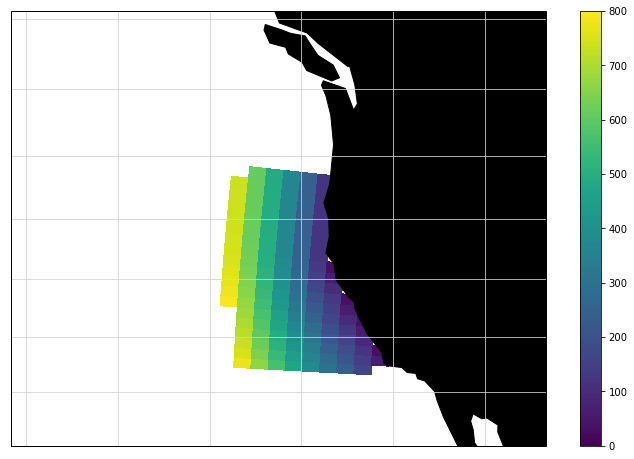

In [114]:
lon = CalCS.TLONG
lat = CalCS.TLAT
dat = np.ma.array(CalCS, mask=np.isnan(CalCS))

import esmtools as et
f, ax = et.vis.make_cartopy(projection=ccrs.Mercator())

plt.pcolormesh(lon-0.5,lat,dat, transform=ccrs.PlateCarree(), vmin=0, vmax=800)
ax.set_extent([-145, -110, 30, 50])
cb = plt.colorbar(ax=ax, pad=0.05)

# Humboldt Current

LAT : 12N to 22N

In [132]:
# Pull out a small box around the CalCS to find the coastline.
a, c = et.filtering.find_indices(ds2.TLONG, ds2.TLAT,
                                 260, -20)
b, d = et.filtering.find_indices(ds2.TLONG, ds2.TLAT,
                                 290, 0)

# Slice out this region
ds2 = ds2.sel(nlat=slice(a,b), nlon=slice(c,d))

In [134]:
# Slim it down to right up to the coastline. Everything is now NaN'ed out
# because any Pacific cells turned to NaN for not being coastline.
# Reference the region_mask portion now
coastal_region = ds2.where(ds2['REGION_MASK'] == 0, drop=True).REGION_MASK

# Find where the first instance of the coastline is.
lon_coastal_index = np.argmax(coastal_region==0, axis=1).values
lat_coastal_index = np.arange(0, coastal_region.shape[0], 1)

# Pointwise indexing to grab those cells
coastline = coastal_region.isel_points(nlat=lat_coastal_index,
                                       nlon=lon_coastal_index)

# Pull out a list for lon and lat
lon_coords = np.asarray(coastline.TLONG) - 360
lat_coords = np.asarray(coastline.TLAT)

# Combine into one 20x2 array with these coordinates.
coastal_coordinates = np.array([lon_coords, lat_coords]).transpose()

In [139]:
global_grid = ds['FG_CO2'][0]

In [140]:
test = global_grid.where((global_grid.TLAT < 0) & (global_grid.TLAT > -40), drop=True)
test = test.where((test.TLONG > 180) & (test.TLONG <300), drop=True)

In [141]:
%%time
dims = test.shape
dist_grid = np.zeros((dims[0], dims[1]))
for i in np.arange(0, dims[0], 1):
    for j in np.arange(0, dims[1], 1):
        if np.isnan(test[i,j]):
            dist_grid[i,j] = np.nan
        else:
            # Coordinates of point on grid.
            if test[i,j].TLONG > 180:
                xpoint = test[i,j].TLONG.values - 360
            else:
                xpoint = test[i,j].TLONG.values
            ypoint = test[i,j].TLAT.values
            grid_coords = (xpoint, ypoint)
            
            # Check distances to every coastal point.
            temp_distance = np.zeros((coastal_coordinates.shape[0]))
            for idx, coords in enumerate(coastal_coordinates):
                temp_distance[idx] = geopy.distance.vincenty(grid_coords, (coords[0], coords[1])).km                
            dist_grid[i,j] = np.nanmin(temp_distance)

CPU times: user 50 s, sys: 12 ms, total: 50 s
Wall time: 50 s


In [143]:
dist2hum = xr.DataArray(dist_grid, dims=['nlat','nlon'])
dist2hum['TLAT'] = test['TLAT']
dist2hum['TLONG'] = test['TLONG']

/glade/u/home/rbrady/.local/lib/python3.6/site-packages/xarray/core/variable.py:1193: RuntimeWarning: invalid value encountered in less_equal
  if not reflexive


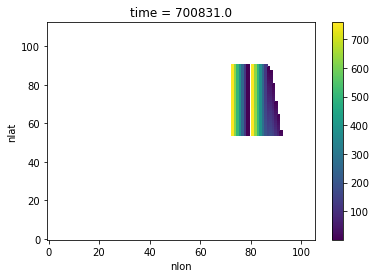

In [146]:
HumCS = dist2hum.where((dist2hum <= 800) & (dist2hum.TLAT > -16) & (dist2hum.TLAT < -6)).plot()

# Canary Current

Trying the old method with new bounds.
